# 12.4a: Measure Dead Token Distribution

**Goal:** Directly measure the statistical distribution of Qwen 3 4B Instruct 2507's dead tokens.

## The Obvious Approach

Instead of guessing σ through parameter sweeps, let's just... measure it.

We have:
- γ_centered (centered embeddings): `gamma_centered_qwen3_4b_instruct_2507.safetensors`
- Black hole mask: `black_hole_mask.safetensors`

Therefore we can compute:
- **σ_measured**: `std(γ_centered[mask])`
- **μ_measured**: `mean(γ_centered[mask])` (should be ≈ 0 since we centered)
- Per-dimension statistics
- Distribution shape (kurtosis, skewness)

This gives us the **empirical parameters** to use in our Gaussian initialization simulator.

## Output

- Measured σ (saved to CSV for use in other notebooks)
- Distribution statistics
- Histogram of element-wise values
- Per-dimension variance profile

## Parameters

In [14]:
# Input paths
GAMMA_CENTERED_PATH = "../data/tensors/gamma_centered_qwen3_4b_instruct_2507.safetensors"
MASK_PATH = "../data/tensors/black_hole_mask.safetensors"

# Output
OUTPUT_CSV = "../data/analysis/qwen_dead_token_statistics.csv"

# Figure settings
DPI = 150
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [15]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from scipy import stats as scipy_stats

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [16]:
print("Loading data...\n")

# Load centered gamma
gamma_data = load_file(GAMMA_CENTERED_PATH)
gamma_centered = gamma_data['gamma_centered'].to(torch.float32)
print(f"✓ Loaded γ_centered")
print(f"  Shape: {gamma_centered.shape}")

# Load black hole mask
mask_data = load_file(MASK_PATH)
mask = mask_data['mask']
print(f"\n✓ Loaded black hole mask")
print(f"  Dead tokens: {mask.sum().item():,}")

# Extract dead token embeddings
dead_tokens = gamma_centered[mask]
print(f"\n✓ Extracted dead token embeddings")
print(f"  Shape: {dead_tokens.shape}")

Loading data...

✓ Loaded γ_centered
  Shape: torch.Size([151936, 2560])

✓ Loaded black hole mask
  Dead tokens: 2,100

✓ Extracted dead token embeddings
  Shape: torch.Size([2100, 2560])


## Compute Global Statistics

In [17]:
print("\nComputing global statistics...\n")

# Flatten to all elements
all_elements = dead_tokens.flatten()

# Compute statistics
mean_measured = all_elements.mean().item()
std_measured = all_elements.std().item()
median_measured = all_elements.median().item()
min_measured = all_elements.min().item()
max_measured = all_elements.max().item()

# Convert to numpy for scipy stats
elements_np = all_elements.cpu().numpy()
skewness = scipy_stats.skew(elements_np)
kurtosis = scipy_stats.kurtosis(elements_np)

print(f"{'='*60}")
print(f"GLOBAL STATISTICS (all elements)")
print(f"{'='*60}")
print(f"Mean (μ):      {mean_measured:+.6e}")
print(f"Std (σ):       {std_measured:.6e}")
print(f"Median:        {median_measured:+.6e}")
print(f"Min:           {min_measured:+.6e}")
print(f"Max:           {max_measured:+.6e}")
print(f"Range:         {max_measured - min_measured:.6e}")
print(f"Skewness:      {skewness:+.3f}")
print(f"Kurtosis:      {kurtosis:+.3f}")
print(f"{'='*60}")

print(f"\n→ Use σ = {std_measured:.3e} for Gaussian initialization")


Computing global statistics...

GLOBAL STATISTICS (all elements)
Mean (μ):      -3.200740e-05
Std (σ):       3.281911e-03
Median:        -9.289976e-05
Min:           -2.559249e-02
Max:           +3.293261e-02
Range:         5.852510e-02
Skewness:      +0.470
Kurtosis:      +11.937

→ Use σ = 3.282e-03 for Gaussian initialization


## Compute Per-Dimension Statistics

In [18]:
print("\nComputing per-dimension statistics...\n")

# Compute std per dimension
per_dim_std = dead_tokens.std(dim=0)  # [2560]
per_dim_mean = dead_tokens.mean(dim=0)  # [2560]

# Statistics of the per-dimension stds
std_of_stds = per_dim_std.std().item()
mean_of_stds = per_dim_std.mean().item()
min_std = per_dim_std.min().item()
max_std = per_dim_std.max().item()

print(f"Per-dimension std:")
print(f"  Mean: {mean_of_stds:.6e}")
print(f"  Std:  {std_of_stds:.6e}")
print(f"  Min:  {min_std:.6e}")
print(f"  Max:  {max_std:.6e}")
print(f"  Range: {max_std - min_std:.6e}")

# Check isotropy (should be roughly uniform across dimensions)
coefficient_of_variation = std_of_stds / mean_of_stds
print(f"\nCoefficient of variation: {coefficient_of_variation:.3f}")
if coefficient_of_variation < 0.1:
    print("→ Distribution is approximately isotropic (uniform across dimensions)")
else:
    print("→ Distribution shows anisotropy (variance differs across dimensions)")


Computing per-dimension statistics...

Per-dimension std:
  Mean: 1.476817e-08
  Std:  3.636488e-07
  Min:  0.000000e+00
  Max:  1.525965e-05
  Range: 1.525965e-05

Coefficient of variation: 24.624
→ Distribution shows anisotropy (variance differs across dimensions)


## Save Statistics to CSV

In [19]:
# Build statistics dictionary
stats = {
    'n_tokens': mask.sum().item(),
    'n_dimensions': dead_tokens.shape[1],
    'mean': mean_measured,
    'std': std_measured,
    'median': median_measured,
    'min': min_measured,
    'max': max_measured,
    'range': max_measured - min_measured,
    'skewness': skewness,
    'kurtosis': kurtosis,
    'per_dim_mean_std': mean_of_stds,
    'per_dim_std_std': std_of_stds,
    'coefficient_of_variation': coefficient_of_variation,
}

# Save to CSV
df_stats = pd.DataFrame([stats])
output_path = Path(OUTPUT_CSV)
df_stats.to_csv(output_path, index=False)

print(f"\n✓ Statistics saved to {output_path}")


✓ Statistics saved to ../data/analysis/qwen_dead_token_statistics.csv


## Figure 1: Element-wise Distribution

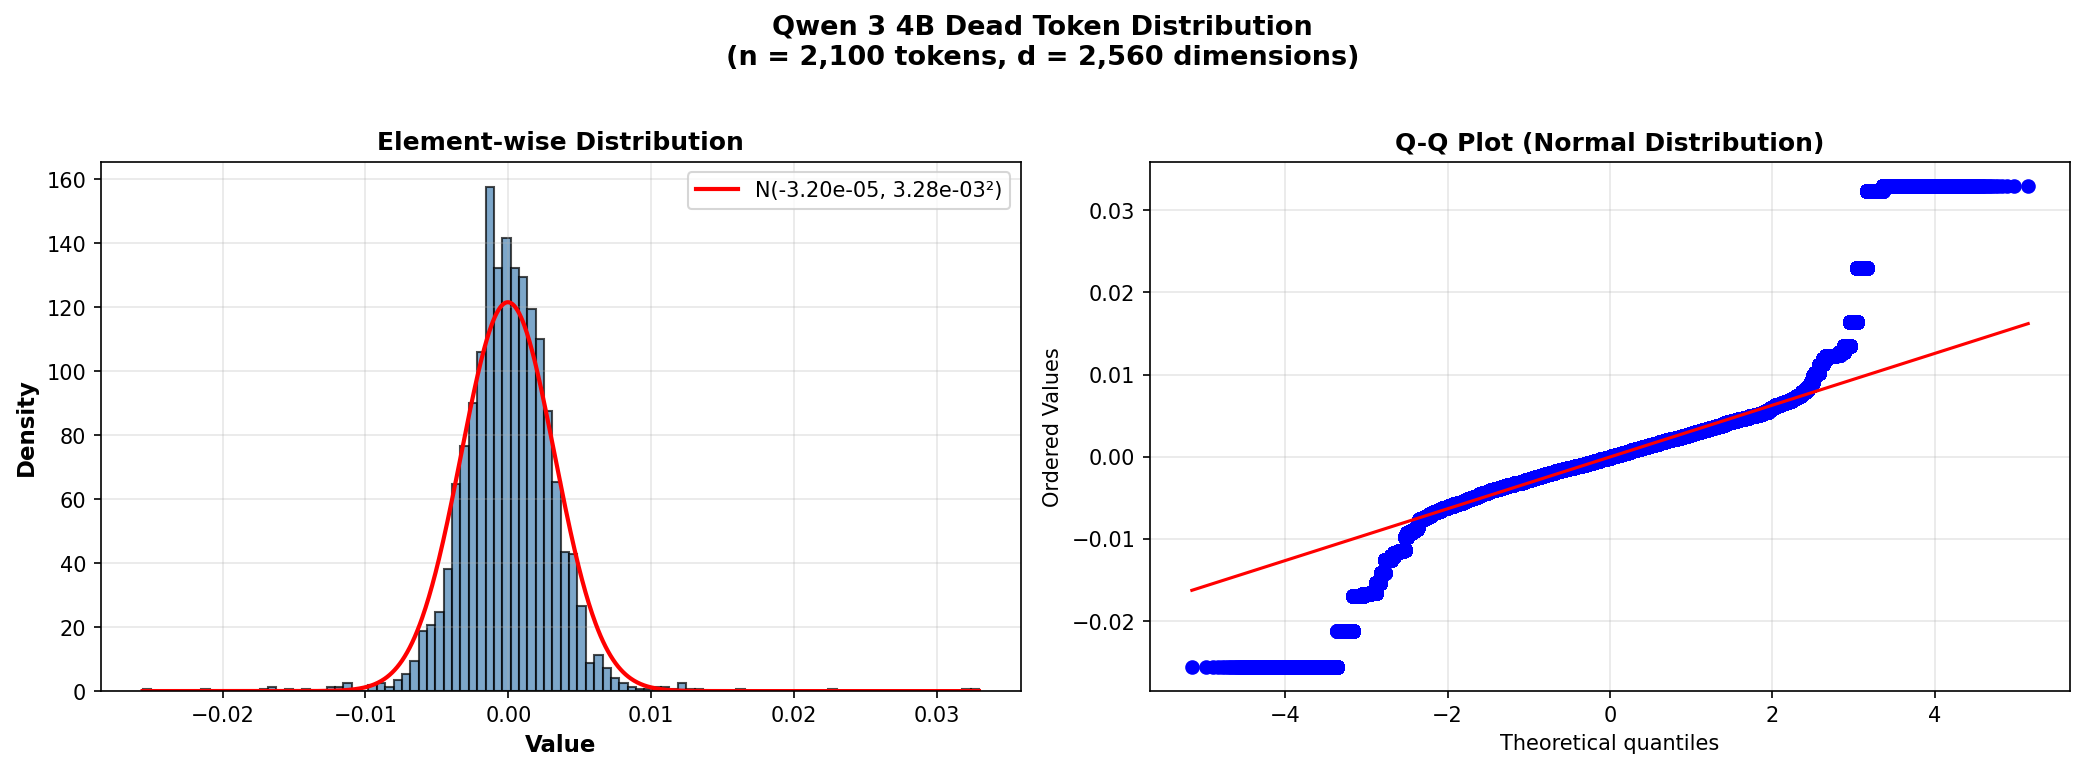

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Histogram
ax = axes[0]
ax.hist(elements_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black', density=True)

# Overlay Gaussian with measured parameters
x = np.linspace(min_measured, max_measured, 1000)
gaussian = scipy_stats.norm.pdf(x, loc=mean_measured, scale=std_measured)
ax.plot(x, gaussian, 'r-', linewidth=2, label=f'N({mean_measured:.2e}, {std_measured:.2e}²)')

ax.set_xlabel('Value', fontsize=11, fontweight='bold')
ax.set_ylabel('Density', fontsize=11, fontweight='bold')
ax.set_title('Element-wise Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Q-Q plot
ax = axes[1]
scipy_stats.probplot(elements_np, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('Qwen 3 4B Dead Token Distribution\n(n = 2,100 tokens, d = 2,560 dimensions)',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Figure 2: Per-Dimension Variance Profile

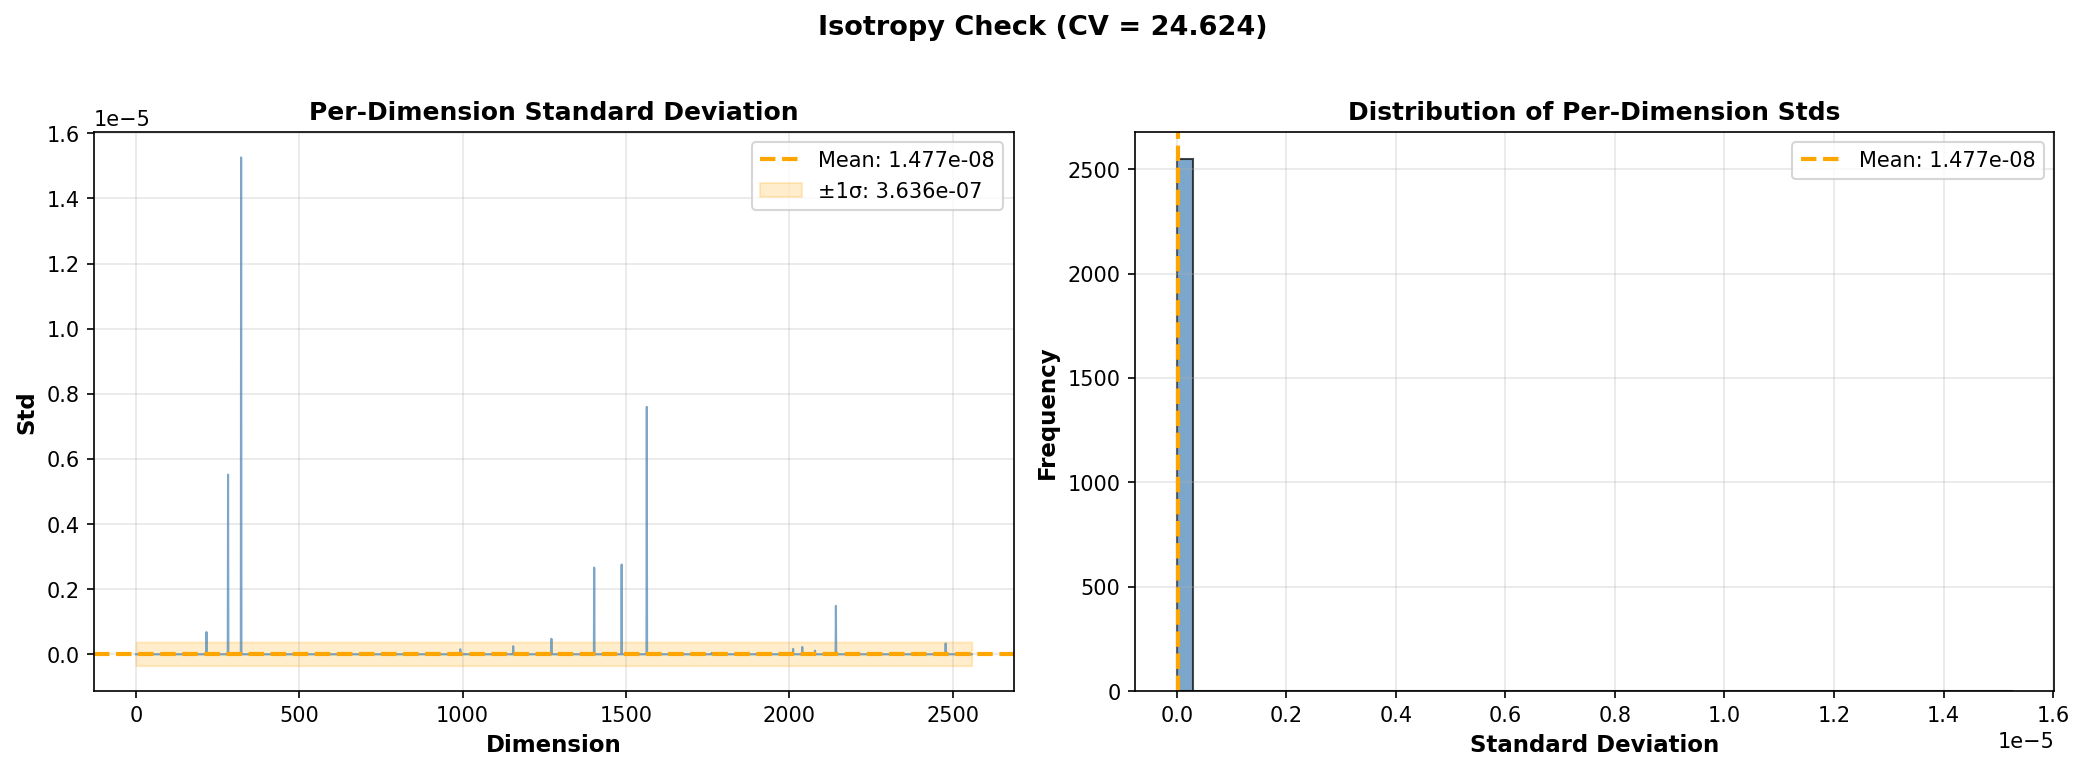

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Per-dimension std
ax = axes[0]
ax.plot(per_dim_std.cpu().numpy(), color='steelblue', linewidth=1, alpha=0.7)
ax.axhline(mean_of_stds, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_of_stds:.3e}')
ax.fill_between(range(len(per_dim_std)), 
                 mean_of_stds - std_of_stds, 
                 mean_of_stds + std_of_stds,
                 color='orange', alpha=0.2, label=f'±1σ: {std_of_stds:.3e}')
ax.set_xlabel('Dimension', fontsize=11, fontweight='bold')
ax.set_ylabel('Std', fontsize=11, fontweight='bold')
ax.set_title('Per-Dimension Standard Deviation', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Histogram of per-dimension stds
ax = axes[1]
ax.hist(per_dim_std.cpu().numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(mean_of_stds, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_of_stds:.3e}')
ax.set_xlabel('Standard Deviation', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Per-Dimension Stds', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Isotropy Check (CV = {coefficient_of_variation:.3f})',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Summary

In [22]:
print(f"\n{'='*60}")
print(f"MEASUREMENT COMPLETE")
print(f"{'='*60}\n")

print(f"Dead tokens in Qwen 3 4B Instruct 2507:")
print(f"  N = {mask.sum().item():,} tokens")
print(f"  d = {dead_tokens.shape[1]:,} dimensions\n")

print(f"Measured distribution parameters:")
print(f"  μ = {mean_measured:+.6e} (expected ≈ 0)")
print(f"  σ = {std_measured:.6e}\n")

print(f"Distribution shape:")
print(f"  Skewness: {skewness:+.3f} (0 = symmetric)")
print(f"  Kurtosis: {kurtosis:+.3f} (0 = Gaussian)\n")

print(f"Isotropy:")
print(f"  CV = {coefficient_of_variation:.3f} (<0.1 = isotropic)\n")

print(f"{'='*60}")
print(f"NEXT STEP")
print(f"{'='*60}")
print(f"\nGenerate synthetic snowballs using σ = {std_measured:.3e}")
print(f"and compare to Qwen statistics.\n")
print(f"{'='*60}")


MEASUREMENT COMPLETE

Dead tokens in Qwen 3 4B Instruct 2507:
  N = 2,100 tokens
  d = 2,560 dimensions

Measured distribution parameters:
  μ = -3.200740e-05 (expected ≈ 0)
  σ = 3.281911e-03

Distribution shape:
  Skewness: +0.470 (0 = symmetric)
  Kurtosis: +11.937 (0 = Gaussian)

Isotropy:
  CV = 24.624 (<0.1 = isotropic)

NEXT STEP

Generate synthetic snowballs using σ = 3.282e-03
and compare to Qwen statistics.

